# Section 4: Memory and Human-in-the-Loop

![HIL](../images/hil.png)

In this section, we'll cover a series of topics that are important to leveraging the full power of LangGraph. Here are the topics

1. Memory: How can I persist information in our app across invocations?
    - Local memory
    - Threads
    - External memory
2. Breakpoints and Human-in-the-loop: How does LangGraph use Memory to enable HIL workflows
3. [Optional] Streaming: How does streaming work in LangGraph

After this section, we'll take a closer look at memory and HIL in LangGraph Studio, as well as production monitoring in LangSmith.

## Setup

You can install the required packages directly to this notebook environment if you cannot use virtual environments for some reason.

In [ ]:
required_packages = [
    "langgraph", 
    "langgraph-sdk", 
    "langgraph-checkpoint-sqlite", 
    "langsmith", 
    "langchain-community", 
    "langchain-core", 
    "langchain-openai", 
    "notebook", 
    "python-dotenv", 
    "chromadb"
]

# Install each package
for package in required_packages:
    %pip install {package}

You can set your environment variables locally in this notebook.

In [ ]:
import os

# Set environment variables
os.environ["OPENAI_API_KEY"] = ""
os.environ["LANGCHAIN_API_KEY"] = ""
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langgraph-101"

Alternatively, load environment variables from a .env file

In [ ]:
from dotenv import load_dotenv
load_dotenv(dotenv_path="../.env", override=True)

Set your LLM in accordance to your model provider

In [2]:
# Set up LLM
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model_name="gpt-4o", temperature=0)

# Azure OpenAI Alternative
# from models import AZURE_OPENAI_GPT_4O
# llm = AZURE_OPENAI_GPT_4O

Our graph is getting pretty big and complex! Let's copy over what we've done through the first three modules

In [ ]:
from utils import get_vector_db_retriever, RAG_PROMPT
from langchain.schema import Document
from typing import List
from typing_extensions import TypedDict, Annotated
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from pydantic import BaseModel, Field
from langgraph.constants import Send
from collections import Counter
from langgraph.graph import StateGraph
from langgraph.graph import START, END
from IPython.display import Image, display

# Fetch retriever
retriever = get_vector_db_retriever()

# Define our GraphState, InputState, and OutputState
def custom_documents_reducer(existing, update):
    # If we passed in a dictionary that asks for "overwrite", then we return the updated documents only
    if isinstance(update, dict) and update["type"] == "overwrite":
        return update["documents"]
    # Otherwise, we simple add the lists
    return existing + update

class GraphState(TypedDict):
    question: str
    rewritten_queries: List[str]
    generation: str
    documents: Annotated[List[Document], custom_documents_reducer]   # We use Annotated to add our custom reducer
    attempted_generations: int

class InputState(TypedDict):
    question: str

class OutputState(TypedDict):
    generation: str
    documents: List[Document]

# Define Nodes and Conditional Edges
def generate_response(state: GraphState):
    print("---GENERATE RESPONSE---")
    question = state["question"]
    documents = state["documents"]
    attempted_generations = state.get("attempted_generations", 0)   # By default we set attempted_generations to 0 if it doesn't exist yet
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    rag_prompt_formatted = RAG_PROMPT.format(context=formatted_docs, question=question)
    generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
    return {
        "generation": generation,
        "attempted_generations": attempted_generations + 1   # In our state update, we increment attempted_generations
    }

class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""
    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )
grade_documents_llm = llm.with_structured_output(GradeDocuments)
grade_documents_system_prompt = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_documents_prompt = "Here is the retrieved document: \n\n {document} \n\n Here is the user question: \n\n {question}"
def grade_documents(state):
    print("---GRADE DOCUMENTS---")
    question = state["question"]
    documents = state["documents"]
    doc_counter = Counter(doc.page_content for doc in documents)
    most_common_contents = doc_counter.most_common(5)
    top_documents = []
    for content, _ in most_common_contents:
        for d in documents:
            if d.page_content == content:
                top_documents.append(d)
                break
    filtered_docs = []
    for d in top_documents:
        grade_documents_prompt_formatted = grade_documents_prompt.format(document=d.page_content, question=question)
        score = grade_documents_llm.invoke(
            [SystemMessage(content=grade_documents_system_prompt)] + [HumanMessage(content=grade_documents_prompt_formatted)]
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": {"type": "overwrite", "documents": filtered_docs}}

def decide_to_generate(state):
    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        print("---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, END---")
        return "none relevant"
    else:
        print("---DECISION: GENERATE---")
        return "some relevant" 

class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""
    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )

grade_hallucinations_llm = llm.with_structured_output(GradeHallucinations)
grade_hallucinations_system_prompt = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n 
     Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""
grade_hallucinations_prompt = "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"
ATTEMPTED_GENERATION_MAX = 3

def grade_hallucinations(state):
    print("---CHECK HALLUCINATIONS---")
    documents = state["documents"]
    generation = state["generation"]
    attempted_generations = state["attempted_generations"]
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    grade_hallucinations_prompt_formatted = grade_hallucinations_prompt.format(
        documents=formatted_docs,
        generation=generation
    )
    score = grade_hallucinations_llm.invoke(
        [SystemMessage(content=grade_hallucinations_system_prompt)] + [HumanMessage(content=grade_hallucinations_prompt_formatted)]
    )
    grade = score.binary_score
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        return "supported"
    elif attempted_generations >= ATTEMPTED_GENERATION_MAX:    # New condition!
        print("---DECISION: TOO MANY ATTEMPTS, GIVE UP---")
        raise RuntimeError("Too many attempted generations with hallucinations, giving up.")
    else:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

class RewrittenQueries(BaseModel):
    """Rewritten queries based on the user's original question."""
    rewritten_queries: List[str] = Field(
        description="A list of rewritten versions of the user's query. Each rewritten version is rewritten differently, rephrased and potentially uses synonyms."
    )

rewritten_query_llm = llm.with_structured_output(RewrittenQueries)
rewritten_query_system_prompt = """You are an analyst in charge of taking a user's question as input, and reframing and rewriting it in different ways.\n
Your goal is to change the phrasing of the question, while making sure that the intent and meaning of the question is the same.\n
Return a list of rewritten_queries. The number will be specified by the user."""
rewritten_query_prompt = "Here is the user's question: \n\n {question}. Return {num_rewrites} queries."

class SampleAnswer(BaseModel):
    """Sample answer for an input question."""
    sample_answer: str = Field(
        description="A concise example answer for a question. This shouldn't exceed three sentences in length."
    )

def generate_rewritten_queries(state):
    print("---GENERATING REWRITTEN VERSIONS OF THE USER'S QUERY---")
    question = state["question"]
    num_rewrites = 3
    rewritten_query_prompt_formatted = rewritten_query_prompt.format(question=question, num_rewrites=num_rewrites)
    response = rewritten_query_llm.invoke(
        [SystemMessage(content=rewritten_query_system_prompt)] + [HumanMessage(content=rewritten_query_prompt_formatted)]
    )
    rewritten_queries = response.rewritten_queries
    return {"rewritten_queries": rewritten_queries}

def continue_to_retrieval_nodes(state: GraphState):
    edges_to_create = []
    edges_to_create.append(Send("retrieve_documents", {"question": state["question"]}))
    for rewritten_query in state["rewritten_queries"]:
        edges_to_create.append(Send("retrieve_documents", {"question": rewritten_query}))
    return edges_to_create

sample_answer_llm = llm.with_structured_output(SampleAnswer)
sample_answer_system_prompt = """You are a novice in charge of taking a user's question as input, and generating a sample answer for it.\n
This sample answer should contain words that would likely be in a real answer, but is not grounded in any factual documents, the way a real answer would be."""
sample_answer_prompt = "Here is the user's question: \n\n {question}."

def retrieve_documents(state):
    print("---RETRIEVE DOCUMENTS---")
    question = state["question"]
    sample_answer_prompt_formatted = sample_answer_prompt.format(question=question)
    response = sample_answer_llm.invoke(
        [SystemMessage(content=sample_answer_system_prompt)] + [HumanMessage(content=sample_answer_prompt_formatted)]
    )
    sample_answer = response.sample_answer
    documents = retriever.invoke(f"{question}: {sample_answer}")    # Now we use our question and sample answer
    return {"documents": documents}



# Define our graph
graph_builder = StateGraph(GraphState, input=InputState, output=OutputState)
graph_builder.add_node("generate_rewritten_queries", generate_rewritten_queries)
graph_builder.add_node("retrieve_documents", retrieve_documents)
graph_builder.add_node("generate_response", generate_response)
graph_builder.add_node("grade_documents", grade_documents)

graph_builder.add_edge(START, "generate_rewritten_queries")
graph_builder.add_conditional_edges(
    "generate_rewritten_queries",
    continue_to_retrieval_nodes,
    ["retrieve_documents"]
)
graph_builder.add_edge("retrieve_documents", "grade_documents")
graph_builder.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "some relevant": "generate_response",
        "none relevant": END
    })
graph_builder.add_conditional_edges(
    "generate_response",
    grade_hallucinations,
    {
        "supported": END,
        "not supported": "generate_response"
    })

graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

## Memory

In every example so far, [state has been transient](https://github.com/langchain-ai/langgraph/discussions/352#discussioncomment-9291220) to a single graph execution. If we invoke our graph for a second time, we are starting with a fresh state. This limits our ability to have multi-turn conversations with interruptions. 

We can use [persistence](https://langchain-ai.github.io/langgraph/how-tos/persistence/) to address this! 
 
LangGraph can use a checkpointer to automatically save the graph state after each step. This built-in persistence layer gives us memory, allowing LangGraph to pick up from the last state update. 

### Adjusting our State for multi-turn conversations

Before we set up memory in our application, let's edit our State and Nodes so that instead of acting a single "question", we instead act on a list of "questions and answers".

We'll call our list "messages". These existing messages will all be used for our retrieval step. And at the end of our flow when our LLM responds, we will add the latest question and answer to our "messages" history. 

In [4]:
from langchain_core.messages import AnyMessage, get_buffer_string
import operator

class GraphState(TypedDict):
    question: str
    messages: Annotated[List[AnyMessage], operator.add]     # We now track a list of messages
    generation: str
    rewritten_queries: List[str]
    documents: Annotated[List[Document], custom_documents_reducer]
    attempted_generations: int

class InputState(TypedDict):
    question: str

class OutputState(TypedDict):
    messages: Annotated[List[AnyMessage], operator.add]     # We output messages now in our OutputState
    documents: List[Document]

Now let's edit our existing Nodes to use `messages` instead of `question` when generating sample answers, grading document relevance, and generating a response.

In [5]:
sample_answer_system_prompt = """You are a novice in charge of taking a conversation and a user's latest question as input, and generating a sample answer for the latest question.\n
This sample answer should contain words that would likely be in a real answer, but is not grounded in any factual documents, the way a real answer would be."""
sample_answer_prompt = "This is the conversation so far {conversation} \n\n. Here is the user's latest question: \n\n {question}."
def retrieve_documents(state):
    print("---RETRIEVE DOCUMENTS---")
    question = state["question"]
    messages = state.get("messages", [])
    conversation = get_buffer_string(messages)
    print(conversation)

    sample_answer_prompt_formatted = sample_answer_prompt.format(question=question, conversation=conversation)  # We use the entire chat history from messages to generate sample answers
    response = sample_answer_llm.invoke(
        [SystemMessage(content=sample_answer_system_prompt)] + [HumanMessage(content=sample_answer_prompt_formatted)]
    )
    sample_answer = response.sample_answer
    documents = retriever.invoke(f"{question}: {sample_answer}")    # Now we use our question and sample answer
    return {"documents": documents}

In [6]:
grade_documents_system_prompt = """You are a grader assessing relevance of a retrieved document to a conversation between a user and an AI assistant, and user's latest question. \n 
    If the document contains keyword(s) or semantic meaning related to the user question, definitely grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals that are not relevant at all. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_documents_prompt = "Here is the retrieved document: \n\n {document} \n\n Here is the conversation so far: \n\n {conversation} \n\n Here is the user question: \n\n {question}"
def grade_documents(state):
    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]
    conversation = get_buffer_string(state["messages"])

    # -- New logic to deduplicate documents our queries --
    doc_counter = Counter(doc.page_content for doc in documents)
    most_common_contents = doc_counter.most_common(5)
    top_documents = []
    for content, _ in most_common_contents:
        for d in documents:
            if d.page_content == content:
                top_documents.append(d)
                break

    # Score each one of our five most common documents
    filtered_docs = []
    for d in top_documents:
        grade_documents_prompt_formatted = grade_documents_prompt.format(document=d.page_content, question=question, conversation=conversation)
        score = grade_documents_llm.invoke(
            [SystemMessage(content=grade_documents_system_prompt)] + [HumanMessage(content=grade_documents_prompt_formatted)]
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": {"type": "overwrite", "documents": filtered_docs}, "question": question, "messages": [HumanMessage(content=question)]}   # We add the question to Messages here

In [7]:
from utils import RAG_PROMPT_WITH_CHAT_HISTORY

def generate_response(state: GraphState):
    print("---GENERATE RESPONSE---")
    documents = state["documents"]
    conversation = get_buffer_string(state["messages"])
    attempted_generations = state.get("attempted_generations", 0)   # By default we set attempted_generations to 0 if it doesn't exist yet
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    
    # RAG generation
    rag_prompt_formatted = RAG_PROMPT_WITH_CHAT_HISTORY.format(context=formatted_docs, conversation=conversation)
    generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
    return {
        "documents": documents,
        "generation": generation,
        "attempted_generations": attempted_generations + 1   # In our state update, we increment attempted_generations
    }

Awesome, we'll add one more node in our graph which configures memory ahead of our next invocation

In [8]:
def configure_memory(state):
    generation = state["generation"]
    return {
        "messages": [generation],   # Add generation to our messages_list
        "attempted_generations": 0,   # Reset this value to 0
        "documents": {"type": "overwrite", "documents": []}    # Reset documents to empty
    }

### Local Memory

Cool, now let's define our graph and add some local memory!

One of the easiest to work with is `MemorySaver`, an in-memory key-value store for Graph state.

All we need to do is compile the graph with a checkpointer, and our graph has memory!

In [ ]:
# Define our graph
graph_builder = StateGraph(GraphState, input=InputState, output=OutputState)
graph_builder.add_node("generate_rewritten_queries", generate_rewritten_queries)
graph_builder.add_node("retrieve_documents", retrieve_documents)
graph_builder.add_node("generate_response", generate_response)
graph_builder.add_node("grade_documents", grade_documents)
graph_builder.add_node("configure_memory", configure_memory)    # New node for configuring memory

graph_builder.add_edge(START, "generate_rewritten_queries")
graph_builder.add_conditional_edges(
    "generate_rewritten_queries",
    continue_to_retrieval_nodes,
    ["retrieve_documents"]
)
graph_builder.add_edge("retrieve_documents", "grade_documents")
graph_builder.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "some relevant": "generate_response",
        "none relevant": END
    })
graph_builder.add_conditional_edges(
    "generate_response",
    grade_hallucinations,
    {
        "supported": "configure_memory",
        "not supported": "generate_response"
    })
graph_builder.add_edge("configure_memory", END)

from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

### Threads

When we use memory, we need to specify a `thread_id`.

This `thread_id` will store our collection of graph states.

* The checkpointer write the state at every step of the graph
* These checkpoints are saved in a thread 
* We can access that thread in the future using the `thread_id`


In [15]:
import uuid
thread_id = str(uuid.uuid4())

In [ ]:
config = {"configurable": {"thread_id": thread_id}}
question = "Can I use LangGraph for customer support? I want to create an agent application."
response = graph.invoke({"question": question}, config)
for m in response["messages"]:
    m.pretty_print()

Let's ask a follow-up with the same thread_id!

In [ ]:
config = {"configurable": {"thread_id": thread_id}}
question = "What models can I use for this?"
response = graph.invoke({"question": question}, config)
for m in response["messages"]:
    m.pretty_print()

__Let's take a look in LangSmith__

### External Memory

In the previous example, we compiled our graph with local memory - but realistically, you'll want to hook this up to a database. Here, we'll show how to use [Sqlite as a checkpointer](https://langchain-ai.github.io/langgraph/concepts/low_level/#checkpointer), but other checkpointers, such as [Postgres](https://langchain-ai.github.io/langgraph/how-tos/persistence_postgres/) are available!

Create a file from your notebooks folder that sits in a directory /state_db/, called example.db

In [18]:
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver

db_path = "state_db/example.db"
conn = sqlite3.connect(db_path, check_same_thread=False)
memory = SqliteSaver(conn)
graph = graph_builder.compile(checkpointer=memory)

Now let's invoke our graph

In [19]:
thread_id_2 = str(uuid.uuid4())

In [ ]:
config = {"configurable": {"thread_id": thread_id_2}}
question = "Can I use LangGraph for customer support? I want to create an agent application."
graph.invoke({"question": question}, config)

Let's confirm that our state is saved locally still

In [ ]:
config = {"configurable": {"thread_id": thread_id_2}}
graph_state = graph.get_state(config)
graph_state

Using database like Sqlite means state is persisted! 

For example, we can re-start the notebook kernel and see that we can still load from Sqlite DB on disk.


## Breakpoints and Human-in-the-loop

Now, let's talk about the motivations for `human-in-the-loop`:

(1) `Approval` - We can interrupt our agent, surface state to a user, and allow the user to accept an action

(2) `Editing` - You can modify the state 

LangGraph offers several ways to get or update agent state to support various `human-in-the-loop` workflows. First, we'll introduce [breakpoints](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/breakpoints/#simple-usage), which provide a simple way to stop the graph at specific steps. We'll show how this enables user `approval`.

![breakpoints.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbae7985b747dfed67775d_breakpoints1.png)

Let's assume that we are concerned about the quality of our retrieved documents, even after grading. All we need to do is simply compile the graph with `interrupt_after=["grade_documents"]`.

This means that the execution will be interrupted after the node `grade_documents` executes. Now, we can inspect the documents before generating a response.

In [22]:
graph = graph_builder.compile(checkpointer=memory, interrupt_after=["grade_documents"])

In [23]:
thread_id_3 = str(uuid.uuid4())

In [ ]:
config = {"configurable": {"thread_id": thread_id_3}}
question = "Can I use LangGraph for building a customer support bot?"
graph.invoke({"question": question}, config)

We can get the state and look at the next node to call.

This is a nice way to see that the graph has been interrupted.

In [ ]:
state = graph.get_state(config)
state.next

Now, we'll introduce a nice trick. When we invoke the graph with `None`, it will just continue from the last state checkpoint!

For clarity, LangGraph will re-emit the current state. And then it will proceed to execute the following steps in the graph, which start with the `generate_response` node.

In [ ]:
response = graph.invoke(None, config)
for m in response["messages"]:
    m.pretty_print()

Now, lets bring these together with a specific user approval step that accepts user input.

This is our human-in-the-loop!

In [33]:
thread_id_4 = str(uuid.uuid4())
config = {"configurable": {"thread_id": thread_id_4}}
question = "Can I use LangGraph for building a customer support bot?"
graph.invoke({"question": question}, config)

---GENERATING REWRITTEN VERSIONS OF THE USER'S QUERY---
---RETRIEVE DOCUMENTS------RETRIEVE DOCUMENTS---

---RETRIEVE DOCUMENTS---



---RETRIEVE DOCUMENTS---

---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---DECISION: GENERATE---


{'messages': [HumanMessage(content='Can I use LangGraph for building a customer support bot?', additional_kwargs={}, response_metadata={})],
 'documents': [Document(metadata={'description': 'Build language agents as graphs', 'language': 'en', 'source': 'https://langchain-ai.github.io/langgraph/tutorials/customer-support/customer-support/', 'title': 'Build a Customer Support Bot'}, page_content="Build a Customer Support Bot¶\nCustomer support bots can free up teams' time by handling routine issues, but it can be hard to build a bot that reliably handles diverse tasks in a way that doesn't leave the user pulling their hair out.\nIn this tutorial, you will build a customer support bot for an airline to help users research and make travel arrangements. You'll learn to use LangGraph's interrupts and checkpointers and more complex state to organize your assistant's tools and manage a user's flight bookings, hotel reservations, car rentals, and excursions. It assumes you are familiar with the

Now, let's take a look at our documents

In [39]:
state = graph.get_state(config)
print(state.values["documents"])

[Document(metadata={'description': 'Build language agents as graphs', 'language': 'en', 'source': 'https://langchain-ai.github.io/langgraph/tutorials/customer-support/customer-support/', 'title': 'Build a Customer Support Bot'}, page_content="Build a Customer Support Bot¶\nCustomer support bots can free up teams' time by handling routine issues, but it can be hard to build a bot that reliably handles diverse tasks in a way that doesn't leave the user pulling their hair out.\nIn this tutorial, you will build a customer support bot for an airline to help users research and make travel arrangements. You'll learn to use LangGraph's interrupts and checkpointers and more complex state to organize your assistant's tools and manage a user's flight bookings, hotel reservations, car rentals, and excursions. It assumes you are familiar with the concepts presented in the LangGraph introductory tutorial.\nBy the end, you'll have built a working bot and gained an understanding of  LangGraph's key co

Once reviewed, we can continue or cancel execution!

In [40]:
# Get user feedback
user_approval = input("Do these documents look good to you? (yes/no): ")

# Check approval
if user_approval.lower() == "yes":
    # If approved, continue the graph execution
    graph.invoke(None, config)
else:
    print("Operation cancelled by user.")

---GENERATE RESPONSE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---


Note that you can also specify `interrupt_before` to pause execution before a certain node executes.

### Dynamic Breakpoints

Breakpoints are set by the developer on a specific node during graph compilation. 

But, sometimes it is helpful to allow the graph **dynamically interrupt** itself!

This is an internal breakpoint, and [can be achieved using `NodeInterrupt`](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/dynamic_breakpoints/#run-the-graph-with-dynamic-interrupt).

This has a few specific benefits: 

(1) you can do it conditionally (from inside a node based on developer-defined logic).

(2) you can communicate to the user why its interrupted (by passing whatever you want to the `NodeInterrupt`).

Let's add a `NodeInterrupt` to our `grade_documents` node instead of always interrupting after it! Specifically, let's only interrupt if no relevant documents can be found, instead of directly ending execution.

In [41]:
from langgraph.errors import NodeInterrupt
def grade_documents(state):
    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]
    conversation = get_buffer_string(state["messages"])

    # -- New logic to deduplicate documents our queries --
    doc_counter = Counter(doc.page_content for doc in documents)
    most_common_contents = doc_counter.most_common(5)
    top_documents = []
    for content, _ in most_common_contents:
        for d in documents:
            if d.page_content == content:
                top_documents.append(d)
                break

    # Score each one of our five most common documents
    filtered_docs = []
    for d in top_documents:
        grade_documents_prompt_formatted = grade_documents_prompt.format(document=d.page_content, question=question, conversation=conversation)
        score = grade_documents_llm.invoke(
            [SystemMessage(content=grade_documents_system_prompt)] + [HumanMessage(content=grade_documents_prompt_formatted)]
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue

    # Note: Added interrupt here!
    if len(filtered_docs) == 0:
        raise NodeInterrupt(f"There are no relevant documents!: {filtered_docs}")
    
    return {"documents": {"type": "overwrite", "documents": filtered_docs}, "question": question, "messages": [HumanMessage(content=question)]}

Let's try it out!

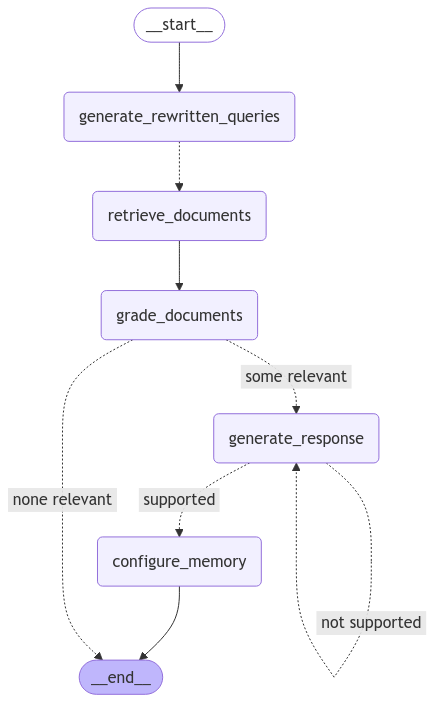

In [42]:
# Define our graph
graph_builder = StateGraph(GraphState, input=InputState, output=OutputState)
graph_builder.add_node("generate_rewritten_queries", generate_rewritten_queries)
graph_builder.add_node("retrieve_documents", retrieve_documents)
graph_builder.add_node("generate_response", generate_response)
graph_builder.add_node("grade_documents", grade_documents)
graph_builder.add_node("configure_memory", configure_memory)

graph_builder.add_edge(START, "generate_rewritten_queries")
graph_builder.add_conditional_edges(
    "generate_rewritten_queries",
    continue_to_retrieval_nodes,
    ["retrieve_documents"]
)
graph_builder.add_edge("retrieve_documents", "grade_documents")
graph_builder.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "some relevant": "generate_response",
        "none relevant": END
    })
graph_builder.add_conditional_edges(
    "generate_response",
    grade_hallucinations,
    {
        "supported": "configure_memory",
        "not supported": "generate_response"
    })
graph_builder.add_edge("configure_memory", END)

memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [43]:
thread_id_5 = str(uuid.uuid4())
config = {"configurable": {"thread_id": thread_id_5}}
question = "Who is Man City's coach?"
graph.invoke({"question": question}, config)

---GENERATING REWRITTEN VERSIONS OF THE USER'S QUERY---
---RETRIEVE DOCUMENTS------RETRIEVE DOCUMENTS---



---RETRIEVE DOCUMENTS---

---RETRIEVE DOCUMENTS---

---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---


{'messages': [],
 'documents': [Document(metadata={'description': 'Build language agents as graphs', 'language': 'en', 'source': 'https://langchain-ai.github.io/langgraph/tutorials/rewoo/rewoo/', 'title': 'Reasoning without Observation'}, page_content='7-5. Men\\\'s singles final\\\\ufeff"}, {\\\'url\\\': \\\'https://www.bbc.com/sport/tennis/68120937\\\', \\\'content\\\': \\\'Live scores, results and order of play\\\\nAlerts: Get tennis news sent to your phone\\\\nRelated Topics\\\\nTop Stories\\\\nFA Cup: Blackburn Rovers v Wrexham - live text commentary\\\\nRussian skater Valieva given four-year ban for doping\\\\nLinks to Barcelona are \\\\\\\'totally untrue\\\\\\\' - Arteta\\\\nElsewhere on the BBC\\\\nThe truth behind the fake grooming scandal\\\\nFeaturing unseen police footage and interviews with the officers at the heart of the case\\\\nDid their father and uncle kill Nazi war criminals?\\\\n A real-life murder mystery following three brothers in their quest for the truth\\\\nW

In [44]:
state = graph.get_state(config)
print(state.next)

('grade_documents',)


In [45]:
graph.invoke(None, config)

---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---


{'messages': [],
 'documents': [Document(metadata={'description': 'Build language agents as graphs', 'language': 'en', 'source': 'https://langchain-ai.github.io/langgraph/tutorials/rewoo/rewoo/', 'title': 'Reasoning without Observation'}, page_content='7-5. Men\\\'s singles final\\\\ufeff"}, {\\\'url\\\': \\\'https://www.bbc.com/sport/tennis/68120937\\\', \\\'content\\\': \\\'Live scores, results and order of play\\\\nAlerts: Get tennis news sent to your phone\\\\nRelated Topics\\\\nTop Stories\\\\nFA Cup: Blackburn Rovers v Wrexham - live text commentary\\\\nRussian skater Valieva given four-year ban for doping\\\\nLinks to Barcelona are \\\\\\\'totally untrue\\\\\\\' - Arteta\\\\nElsewhere on the BBC\\\\nThe truth behind the fake grooming scandal\\\\nFeaturing unseen police footage and interviews with the officers at the heart of the case\\\\nDid their father and uncle kill Nazi war criminals?\\\\n A real-life murder mystery following three brothers in their quest for the truth\\\\nW

### Editing State

We're stuck here! As we are running the same node, we can't progress. To complete this toy example, we can edit the state here with `update_state`, and then continue. Let's add a document about Man City's coach.

Note: These update use the same reducers that you defined in your State class.

In [46]:
graph.update_state(
    config,
    {"documents": {"type": "overwrite", "documents": [Document(page_content="Man City's coach is Pep Guardiola!")]}},
    as_node="grade_documents"
)

---DECISION: GENERATE---


{'configurable': {'thread_id': '09424302-b69f-4bec-8989-dfbbf5ccdcd1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efcc74c-d587-65b4-8003-25731ca24369'}}

In [47]:
graph.invoke(None, config)

---GENERATE RESPONSE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---


{'messages': [AIMessage(content='Pep Guardiola is the coach of Manchester City.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 87, 'total_tokens': 97, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_d28bcae782', 'finish_reason': 'stop', 'logprobs': None}, id='run-18237c0e-dea9-49c4-b98c-508d8e4b0ae5-0', usage_metadata={'input_tokens': 87, 'output_tokens': 10, 'total_tokens': 97})],
 'documents': []}

## [Optional] Streaming

LangGraph is built with [first class support for streaming](https://langchain-ai.github.io/langgraph/concepts/low_level/#streaming).

### Streaming State

Let's talk about ways to [stream our graph state](https://langchain-ai.github.io/langgraph/concepts/low_level/#streaming).

`.stream` and `.astream` are sync and async methods for streaming back results. 
 
LangGraph supports a few [different streaming modes](https://langchain-ai.github.io/langgraph/how-tos/stream-values/) for [graph state](https://langchain-ai.github.io/langgraph/how-tos/stream-values/):
 
* `values`: This streams the full state of the graph after each node is called.
* `updates`: This streams updates to the state of the graph after each node is called.

![values_vs_updates.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbaf892d24625a201744e5_streaming1.png)

Let's look at `stream_mode="updates"`.

Because we stream with `updates`, we only see updates to the state after node in the graph is run.

Each `chunk` is a dict with `node_name` as the key and the updated state as the value.

Let's try both of these streaming modes

In [ ]:
question = "Can I use LangGraph for customer support? I want to create an agent application."
for chunk in graph.stream({"question": question}, stream_mode="updates"):
    print(chunk)

Now, let's stream the full state every time with `values`

In [ ]:
question = "Can I use LangGraph for customer support? I want to create an agent application."
for chunk in graph.stream({"question": question}, stream_mode="values"):
    print(chunk.keys())

### Streaming Events

We often want to stream more than graph state.

In particular, with chat model calls it is common to stream the tokens as they are generated.

We can do this [using the `.astream_events` method](https://langchain-ai.github.io/langgraph/how-tos/streaming-from-final-node/#stream-outputs-from-the-final-node), which streams back events as they happen inside nodes!

Each event is a dict with a few keys:
 
* `event`: This is the type of event that is being emitted. 
* `name`: This is the name of event.
* `data`: This is the data associated with the event.
* `metadata`: Contains`langgraph_node`, the node emitting the event.

Let's have a look.

In [ ]:
question = "Can I use LangGraph for customer support? I want to create an agent application."
async for event in graph.astream_events({"question": question}, version="v2"):
    print(f"Node: {event['metadata'].get('langgraph_node','')}. Type: {event['event']}. Name: {event['name']}")

The central point is that tokens from chat models within your graph have the `on_chat_model_stream` type.

We can use `event['metadata']['langgraph_node']` to select the node to stream from.

And we can use `event['data']` to get the actual data for each event, which in this case is an `AIMessageChunk`. 

In [ ]:
node_to_stream = 'generate_response'
question = "Can I use LangGraph for customer support? I want to create an agent application."
async for event in graph.astream_events({"question": question}, version="v2"):
    # Get chat model tokens from a particular node 
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        print(event["data"])

We can see the response for this particular node stream back one token at at time!